In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow_probability.substrates import numpy as tfp
from cmdstanpy import CmdStanModel, set_cmdstan_path
import arviz as az

In [29]:
X = pd.read_csv("../Datasets/covariates.csv")
Y = pd.read_csv("../Datasets/Dataset_120.csv")
Y.loc[:,'Count_120'] = pd.to_numeric(Y['Count_120']).astype('Int64')
X = pd.get_dummies(X ,columns = ['Type'] ,prefix = 'type', drop_first = True)
X.loc[X['Station'] == 10171, 'Quota'] = 10

In [30]:
rows_to_drop_Y = Y[Y['Count_120'].isna()].index

# Remove corresponding rows from dataset X
X = X.drop(index=rows_to_drop_Y)
Y = Y.drop(index=rows_to_drop_Y)

# If you want to reset the index after dropping rows
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)

In [31]:
stations = X['Station']
years = X['Year'] - 2009
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]

In [32]:
len(stations)

3840

In [33]:
base_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;
  int<lower=1> nstations;


  array[N] int<lower=1> station;
  array[N] int<lower=1> year;
  // array[N] int<lower=4, upper=10> month;

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
  //vector[nstations] eta; // Random effects for comuni
  //vector[nyears] xi; // Random effects for years

  //real<lower=0> sigma0; // Standard deviation for beta
  //real<lower=0> sigma1; // Standard deviation for xi
  //real<lower=0> sigma2; // Standard deviation for eta
}

transformed parameters {
    vector[N] lambda;
    //vector[N] intercept;
    vector[N] fix_eff;

    //intercept = xi[year] + eta[station];
    fix_eff = X * beta;

    //lambda = exp(intercept + fix_eff);
    lambda = exp(fix_eff);
}

model {

  beta ~ normal(0, 2);
  //xi ~ normal(0, 2);
  //eta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);


}
generated quantities{
 vector[N] log_lik;
 for(i in 1:N){
   log_lik [ i ] = poisson_lpmf (y [ i ] |lambda[i]) ;
}
}

"""

stan_file = "./base.stan"

with open(stan_file, "w") as f:
    print(base_model, file=f)

model_base = CmdStanModel(stan_file=stan_file)

10:28:08 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\base.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\base.exe
10:29:01 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\base.exe


In [34]:
X = X.drop(['Year','Station','Month'], axis  = 1)

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)
X_std.loc[:,"type_rural"] = X.loc[:,"type_rural"]
X_std.loc[:,"type_urban"] = X.loc[:,"type_urban"]
X_std.loc[:,"type_rural"] = pd.to_numeric(X_std.loc[:,"type_rural"]).astype('Int64')
X_std.loc[:,"type_urban"] = pd.to_numeric(X_std.loc[:,"type_urban"]).astype('Int64')
X_std.head()

mean_temperature  mean_precipitation_sum  mean_precipitation_hours  \
0         -1.427024               -0.608034                 -0.028251   
1         -0.676275                2.540869                  2.016045   
2          0.428463               -0.188775                  0.329701   
3          1.453029               -1.003430                 -0.981119   
4          0.529757                1.317785                  0.374383   

   mean_windspeed_10m_max  mean_radiation_sum  count_highwind  \
0                0.226227           -0.005763        0.064719   
1                0.514356            0.171209        0.590376   
2               -0.115611            0.813638       -0.101560   
3                0.160412            1.249078        0.027172   
4                0.023923           -0.016637        0.268545   

   max_consecutive_highwind_days   Densità     Quota  type_rural  type_urban  
0                      -0.210751 -0.316079 -0.119963           0           1  
1                       0.589728 -0.316079 -0.119963           0           1  
2                      -0.210751 -0.316079 -0.119963           0           1  
3                       0.589728 -0.316079 -0.119963           0           1  
4                       0.589728 -0.316079 -0.119963           0           1

In [36]:
data = {
    "N": len(Y),
    "P": X_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations,
    "year": years,
    "y": Y['Count_120'],
    "X": X_std
}


fit = model_base.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_az = az.from_cmdstanpy(fit)

10:30:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▍        | 00:00 Status





chain 1 |██▊       | 00:02 Iteration:   1 / 500 [  0%]  (Warmup)


chain 1 |████▎     | 00:05 Iteration: 100 / 500 [ 20%]  (Warmup)


chain 1 |█████▋    | 00:07 Iteration: 200 / 500 [ 40%]  (Warmup)

chain 1 |████████▌ | 00:12 Iteration: 301 / 500 [ 60%]  (Sampling)


chain 1 |██████████| 00:17 Iteration: 400 / 500 [ 80%]  (Sampling)
chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     


10:31:15 - cmdstanpy - INFO - CmdStan done processing.


In [37]:
posterior_az['log_likelihood']

<xarray.Dataset>
Dimensions:        (chain: 4, draw: 200, log_lik_dim_0: 3840)
Coordinates:
  * chain          (chain) int32 0 1 2 3
  * draw           (draw) int32 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * log_lik_dim_0  (log_lik_dim_0) int32 0 1 2 3 4 ... 3835 3836 3837 3838 3839
Data variables:
    log_lik        (chain, draw, log_lik_dim_0) float64 -2.237 ... -0.3024
Attributes:
    created_at:                 2023-12-14T09:31:23.662867
    arviz_version:              0.17.0.dev0
    inference_library:          cmdstanpy
    inference_library_version:  1.2.0

c:\Users\matte\anaconda3\envs\stan\lib\site-packages\arviz\plots\traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (7691), generating only 20 plots
  warnings.warn(


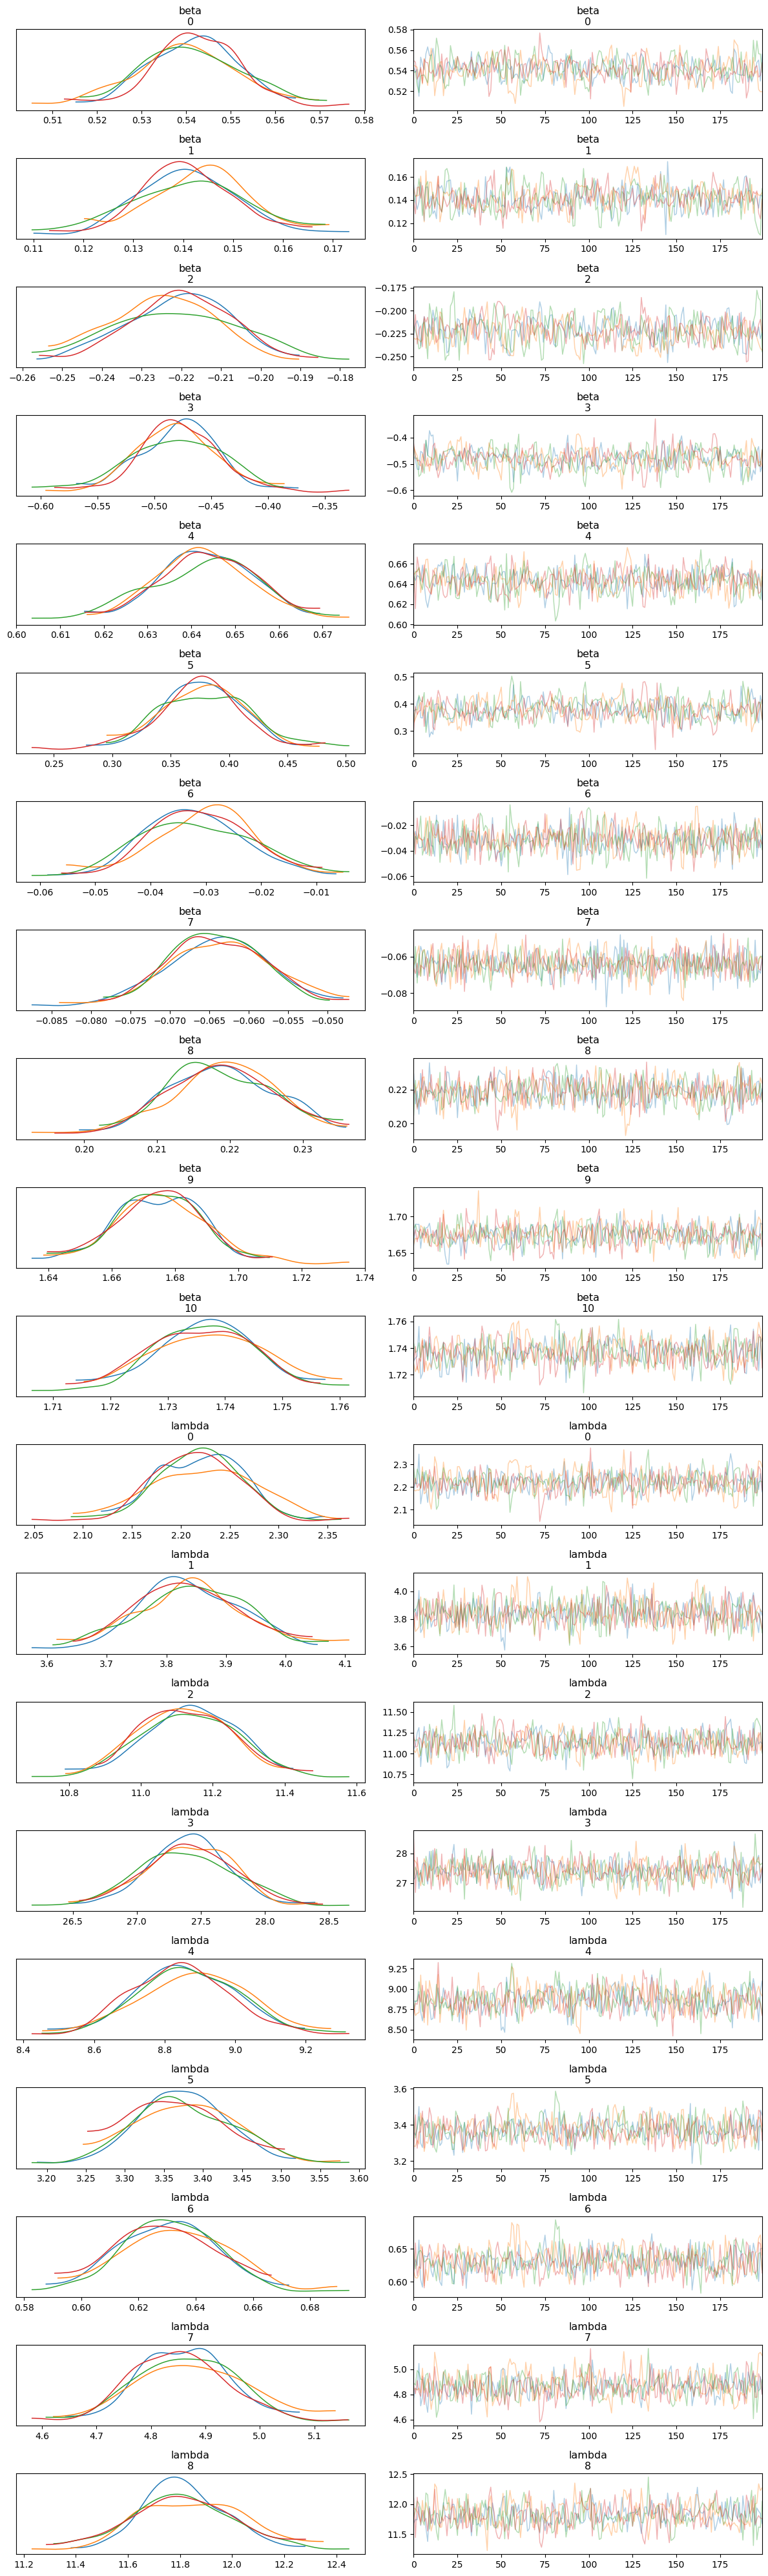

In [39]:
az.plot_trace(posterior_az, compact=False)
plt.tight_layout()
plt.show()

In [40]:
posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

In [41]:
lam = posterior_az['posterior']['lambda']
lam

<xarray.DataArray 'lambda' (chain: 4, draw: 200, lambda_dim_0: 3840)>
array([[[ 2.18505 ,  3.86319 , 11.0534  , ...,  3.01735 ,  0.601166,
          0.293876],
        [ 2.21905 ,  3.87195 , 11.1017  , ...,  3.03567 ,  0.617064,
          0.299336],
        [ 2.21299 ,  3.82067 , 11.2476  , ...,  3.03671 ,  0.604274,
          0.296914],
        ...,
        [ 2.18858 ,  3.70102 , 11.1148  , ...,  3.07782 ,  0.611442,
          0.298844],
        [ 2.25873 ,  3.87135 , 11.1406  , ...,  3.04995 ,  0.61437 ,
          0.305532],
        [ 2.1788  ,  3.82739 , 11.1185  , ...,  3.06459 ,  0.618413,
          0.306283]],

       [[ 2.18724 ,  3.81599 , 11.0394  , ...,  3.05758 ,  0.615753,
          0.298748],
        [ 2.18256 ,  3.70894 , 11.011   , ...,  3.07122 ,  0.611345,
          0.300771],
        [ 2.18691 ,  3.72367 , 11.0647  , ...,  3.05018 ,  0.60276 ,
          0.298111],
...
        [ 2.22015 ,  3.83534 , 11.3744  , ...,  3.05562 ,  0.617898,
          0.297976],
        [ 2.22648 ,  3.79548 , 11.323   , ...,  3.05838 ,  0.618888,
          0.299987],
        [ 2.22187 ,  3.69967 , 11.0053  , ...,  3.07023 ,  0.612456,
          0.309138]],

       [[ 2.19836 ,  3.7209  , 11.2145  , ...,  3.05584 ,  0.606909,
          0.299937],
        [ 2.23878 ,  3.84557 , 11.0784  , ...,  3.05522 ,  0.628149,
          0.310081],
        [ 2.19685 ,  3.79203 , 11.0832  , ...,  3.03916 ,  0.606023,
          0.296577],
        ...,
        [ 2.29016 ,  3.84222 , 11.2086  , ...,  3.03139 ,  0.618675,
          0.308538],
        [ 2.27724 ,  3.79668 , 11.2516  , ...,  2.98321 ,  0.607969,
          0.308385],
        [ 2.18633 ,  3.7313  , 11.0239  , ...,  3.05978 ,  0.612043,
          0.302394]]])
Coordinates:
  * chain         (chain) int32 0 1 2 3
  * draw          (draw) int32 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * lambda_dim_0  (lambda_dim_0) int32 0 1 2 3 4 5 ... 3835 3836 3837 3838 3839

In [81]:
lam.shape
lam.mean(axis=0).shape

(200, 3840)

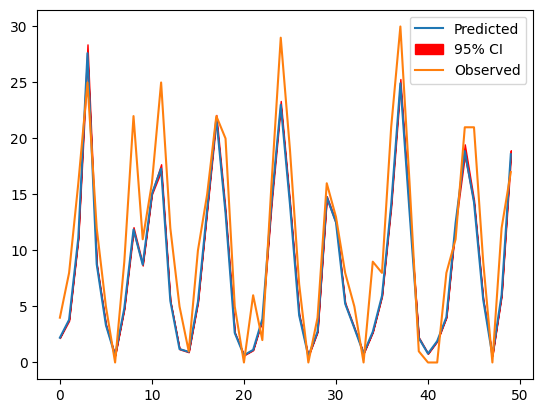

In [86]:
# Generating posterior predictive distribution confidence intervals
preds = lam.mean(axis=0)
lower = np.percentile(lam, 2.5, axis=0)
upper = np.percentile(lam, 97.5, axis=0)
x = np.arange(0, 50)
plt.plot(x, preds[0, x], label="Predicted")
plt.fill_between(x, lower[0,x], upper[0,x], alpha=1, label="95% CI", color='red')
plt.plot(x, Y.loc[x, 'Count_120'], label="Observed")
plt.legend()
plt.show()




In [88]:
#Identifting outliers
#We identify outliers by looking at the observations
#that have a large difference between the observed and
#predicted values

outliers = np.where(np.abs(preds.loc[0,:] - Y['Count_120']) > 10)[0]
print(outliers)
print(outliers.shape)


[   8   56   80  132  211  238  310  346  383  384  391  410  422  429
  478  519  599  605  647  648  688  689  739  747  752  753  757  758
  769  770  775  776  781  782  833  842  876  877  913  925  926  931
  943  957  958  963  964  969  971  976  977  978  984  985  990  991
  992  997  998  999 1021 1058 1065 1066 1073 1078 1079 1080 1101 1136
 1142 1143 1171 1222 1260 1324 1332 1385 1386 1526 1583 1590 1591 1709
 1710 1718 1723 1724 1725 1731 1743 1744 1745 1750 1756 1757 1758 1763
 1769 1770 1774 1777 1778 1783 1784 1786 1790 1791 1792 1857 1859 1871
 1878 1879 1889 1983 2020 2026 2033 2041 2047 2055 2073 2089 2090 2105
 2137 2140 2175 2227 2234 2259 2305 2306 2359 2399 2462 2464 2574 2580
 2622 2648 2659 2661 2662 2663 2668 2673 2684 2685 2687 2695 2697 2698
 2707 2708 2709 2713 2714 2715 2718 2719 2721 2722 2723 2730 2733 2736
 2737 2742 2748 2749 2755 2773 2780 2812 2818 2819 2824 2825 2826 2840
 2846 2847 2851 2857 2858 2859 2864 2865 2866 2867 2871 2872 2873 2878
 2879 

In [90]:
# We identify the outliers using the 95% confidence interval

outliers = np.where((lower[1,:] > Y['Count_120']) | (upper[1,:] < Y['Count_120']))[0]
outliers.shape

(3768,)

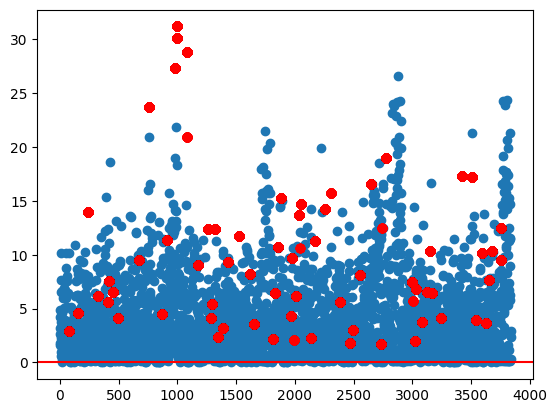

[   8   56   80  132  211  238  310  346  383  384  391  410  422  429
  478  519  599  605  647  648  688  689  739  747  752  753  757  758
  769  770  775  776  781  782  833  842  876  877  913  925  926  931
  943  957  958  963  964  969  971  976  977  978  984  985  990  991
  992  997  998  999 1021 1058 1065 1066 1073 1078 1079 1080 1101 1136
 1142 1143 1171 1222 1260 1324 1332 1385 1386 1526 1583 1590 1591 1709
 1710 1718 1723 1724 1725 1731 1743 1744 1745 1750 1756 1757 1758 1763
 1769 1770 1774 1777 1778 1783 1784 1786 1790 1791 1792 1857 1859 1871
 1878 1879 1889 1983 2020 2026 2033 2041 2047 2055 2073 2089 2090 2105
 2137 2140 2175 2227 2234 2259 2305 2306 2359 2399 2462 2464 2574 2580
 2622 2648 2659 2661 2662 2663 2668 2673 2684 2685 2687 2695 2697 2698
 2707 2708 2709 2713 2714 2715 2718 2719 2721 2722 2723 2730 2733 2736
 2737 2742 2748 2749 2755 2773 2780 2812 2818 2819 2824 2825 2826 2840
 2846 2847 2851 2857 2858 2859 2864 2865 2866 2867 2871 2872 2873 2878
 2879 

In [107]:
#identifying outliers through residuals
#We identify outliers by looking at the observations
#that have a large difference between the observed and
#predicted values

idx_over_30 = np.where(preds> 30)[1]

residuals = np.abs(Y['Count_120'] - preds.loc[0,:])

#plot these residuals

plt.scatter(np.arange(0, len(residuals)),residuals)
plt.scatter(idx_over_30, residuals[idx_over_30], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

outliers = np.where(residuals > 10)[0]
print(outliers)
print(outliers.shape)

total_outliers = np.unique(np.concatenate((outliers, idx_over_30)))
print(total_outliers)
print(total_outliers.shape)

In [141]:
# plot a map of the residuals where you can easily identify ste stations with high residuals

mask = residuals > 10
mask = mask.astype(int)

# group by station
mask = mask.groupby(stations).sum()
mask = mask.reset_index()
mask.columns = ['Station', 'Count']
mask = mask.sort_values(by='Count', ascending=False)
mask = mask.reset_index(drop=True)
print(mask)


    Station  Count
0     10025     35
1     12020     33
2      9991     27
3      6804     26
4      5739     21
5      9997      9
6      5732      8
7      5742      8
8      5735      7
9      6884      7
10    10437      6
11     6904      6
12     5749      5
13     5719      5
14    10584      5
15     6818      5
16     9861      5
17     5730      4
18     5738      4
19     9972      4
20    10171      3
21    10454      3
22    10463      3
23     9899      3
24     5707      3
25     5721      3
26     6665      3
27    10081      2
28    10282      2
29     5717      2
30     5960      2
31     5952      2
32    10041      2
33    10288      2
34     5750      2
35     5718      1
36     5725      1
37     9856      1
38     5710      1
39     6582      1
40     9882      1
41     6832      1
42    10270      0
43     9925      0
44     6691      0


In [142]:
stations_to_rm = mask[mask['Count'] > 10]['Station'].values
print(stations_to_rm)

[10025 12020  9991  6804  5739]


In [124]:
mae = np.mean(residuals)
print(mae)
mse = np.mean(residuals**2)
print(mse)

3.7872486944010415
29.43998891229832


In [112]:
transformed_stations = pd.Series(transformed_stations)
years = pd.Series(years)

data_no_out = {
    "N": len(Y) - len(total_outliers),
    "P": X_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations.drop(index=total_outliers),
    "year": years.drop(index=total_outliers),
    "y": Y['Count_120'].drop(index=total_outliers),
    "X": X_std.drop(index=total_outliers)
}


fit_2 = model_base.sample(data=data_no_out, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_az_2 = az.from_cmdstanpy(fit_2) 

11:44:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▍        | 00:00 Status





chain 1 |████▎     | 00:03 Iteration: 100 / 500 [ 20%]  (Warmup)




chain 1 |█████▋    | 00:06 Iteration: 200 / 500 [ 40%]  (Warmup)


chain 1 |████████▌ | 00:10 Iteration: 301 / 500 [ 60%]  (Sampling)


chain 1 |██████████| 00:15 Iteration: 400 / 500 [ 80%]  (Sampling)
chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     


11:44:44 - cmdstanpy - INFO - CmdStan done processing.


c:\Users\matte\anaconda3\envs\stan\lib\site-packages\arviz\plots\traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (7061), generating only 20 plots
  warnings.warn(


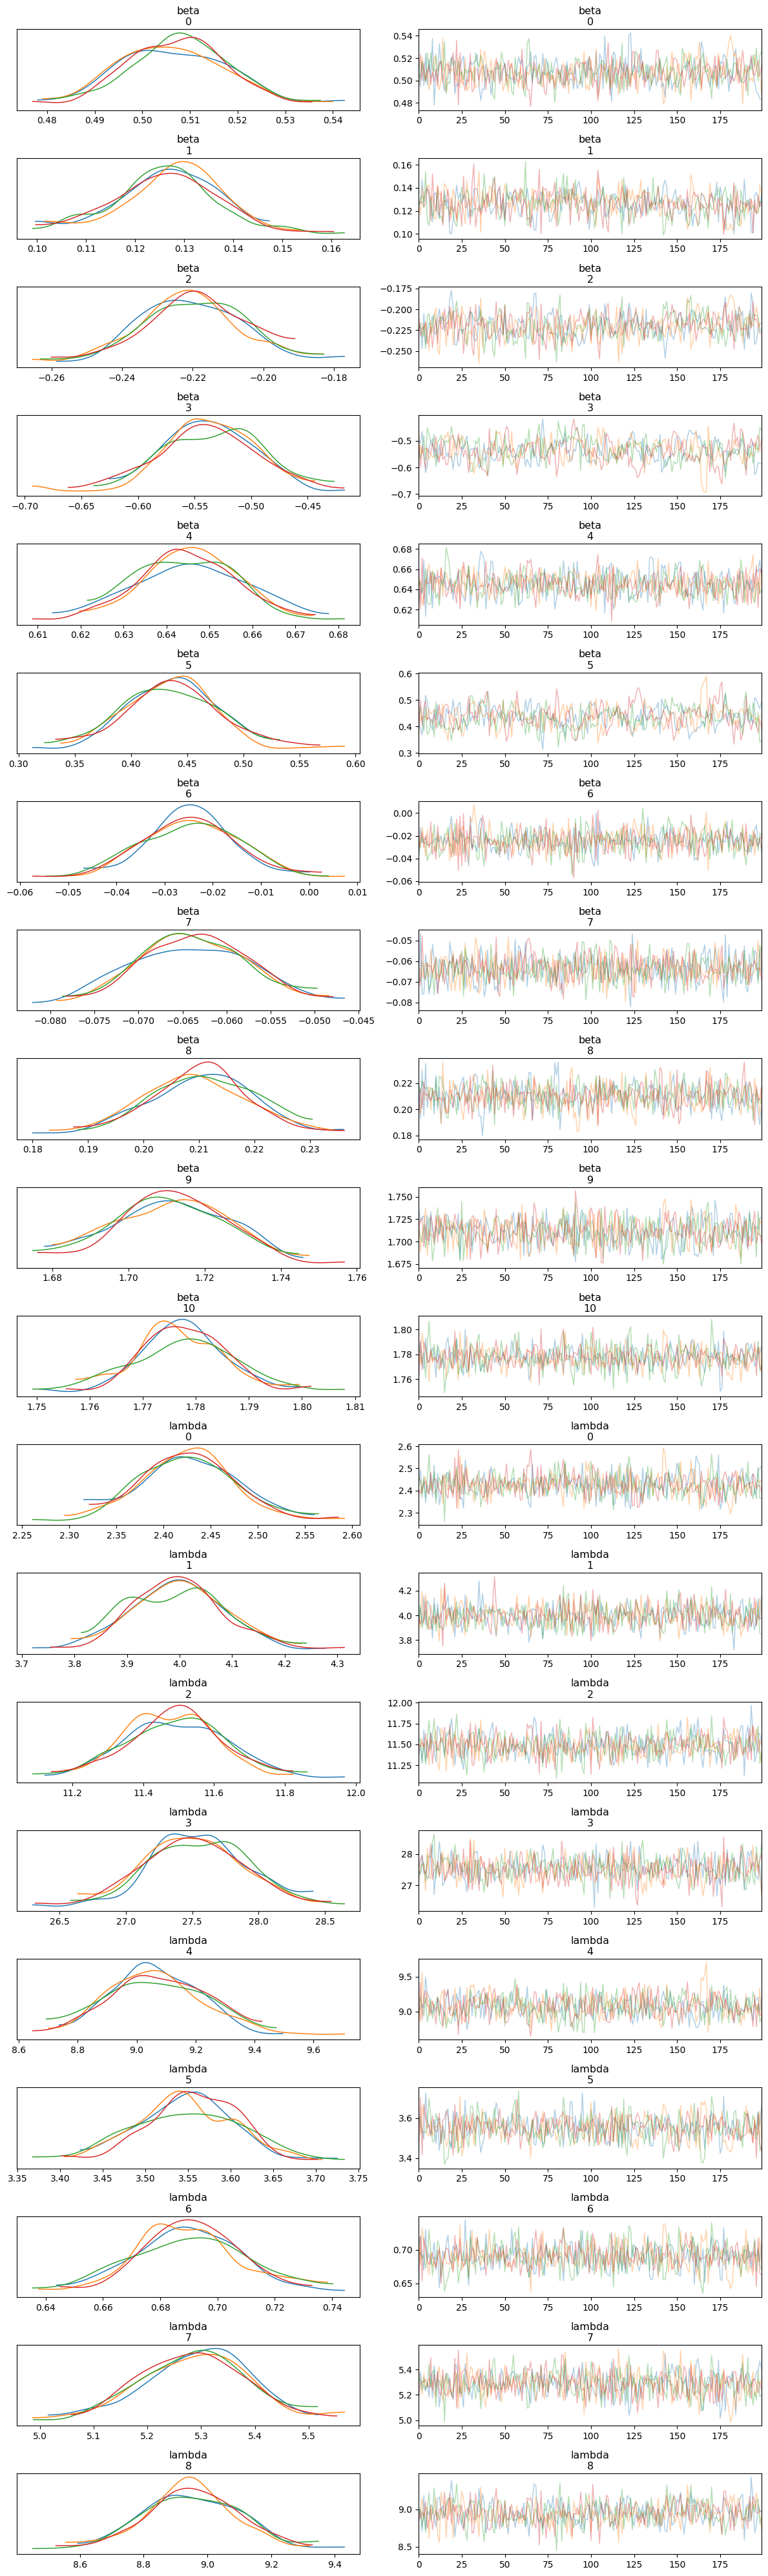

In [113]:
az.plot_trace(posterior_az_2, compact=False)
plt.tight_layout()
plt.show()

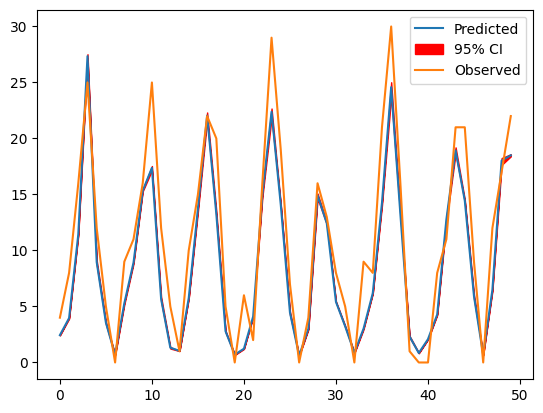

In [156]:
lam_2 = posterior_az_2['posterior']['lambda']

pred_2 = lam_2.mean(axis=0)
lower_2 = np.percentile(lam_2, 2.5, axis=0)
upper_2 = np.percentile(lam_2, 97.5, axis=0)

Y_no_out = Y.drop(index=total_outliers)
Y_no_out = Y_no_out.reset_index(drop=True)
x = np.arange(0, 50)
plt.plot(x, pred_2[0, x], label="Predicted")
plt.fill_between(x, lower_2[0,x], upper_2[0,x], alpha=1, label="95% CI", color='red')
plt.plot(x, Y_no_out.loc[x, 'Count_120'], label="Observed")
plt.legend()
plt.show()


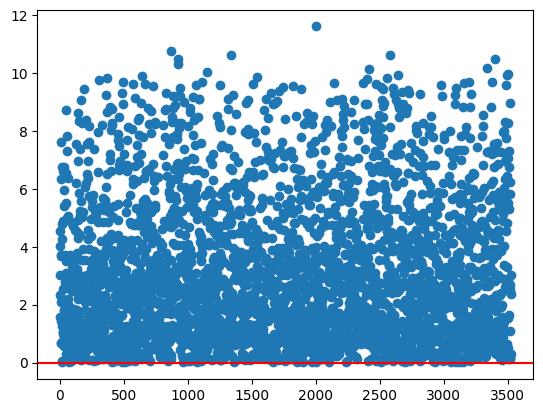

In [122]:
residuals_2 = np.abs(Y_no_out['Count_120'] - pred_2.loc[0,:])

#plot these residuals

plt.scatter(np.arange(0, len(residuals_2)),residuals_2)
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [123]:
mae_2 = np.mean(residuals_2)
print(mae_2)
mse_2 = np.mean(residuals_2**2)
print(mse_2)

2.9688562809929073
14.679713320723216


In [149]:
transformed_stations = pd.Series(transformed_stations)
years = pd.Series(years)

data_no_stat = {
    "N": len(Y.loc[~Y['idSensore'].isin(stations_to_rm),:]),
    "P": X_std.shape[1],
    "nyears": 13,
    "nstations": 45 - len(stations_to_rm),
    "station": transformed_stations.loc[~Y['idSensore'].isin(stations_to_rm)],
    "year": years.loc[~Y['idSensore'].isin(stations_to_rm)],
    "y": Y.loc[~Y['idSensore'].isin(stations_to_rm),'Count_120'],
    "X": X_std.loc[~Y['idSensore'].isin(stations_to_rm),:]
}


fit_3 = model_base.sample(data=data_no_stat, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_az_3 = az.from_cmdstanpy(fit_3) 

12:32:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█▍        | 00:00 Status
chain 1 |██▊       | 00:01 Iteration:   1 / 500 [  0%]  (Warmup)





chain 1 |████▎     | 00:04 Iteration: 100 / 500 [ 20%]  (Warmup)


chain 1 |█████▋    | 00:07 Iteration: 200 / 500 [ 40%]  (Warmup)


chain 1 |████████▌ | 00:12 Iteration: 301 / 500 [ 60%]  (Sampling)


chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     


12:33:14 - cmdstanpy - INFO - CmdStan done processing.


c:\Users\matte\anaconda3\envs\stan\lib\site-packages\arviz\plots\traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (6837), generating only 20 plots
  warnings.warn(


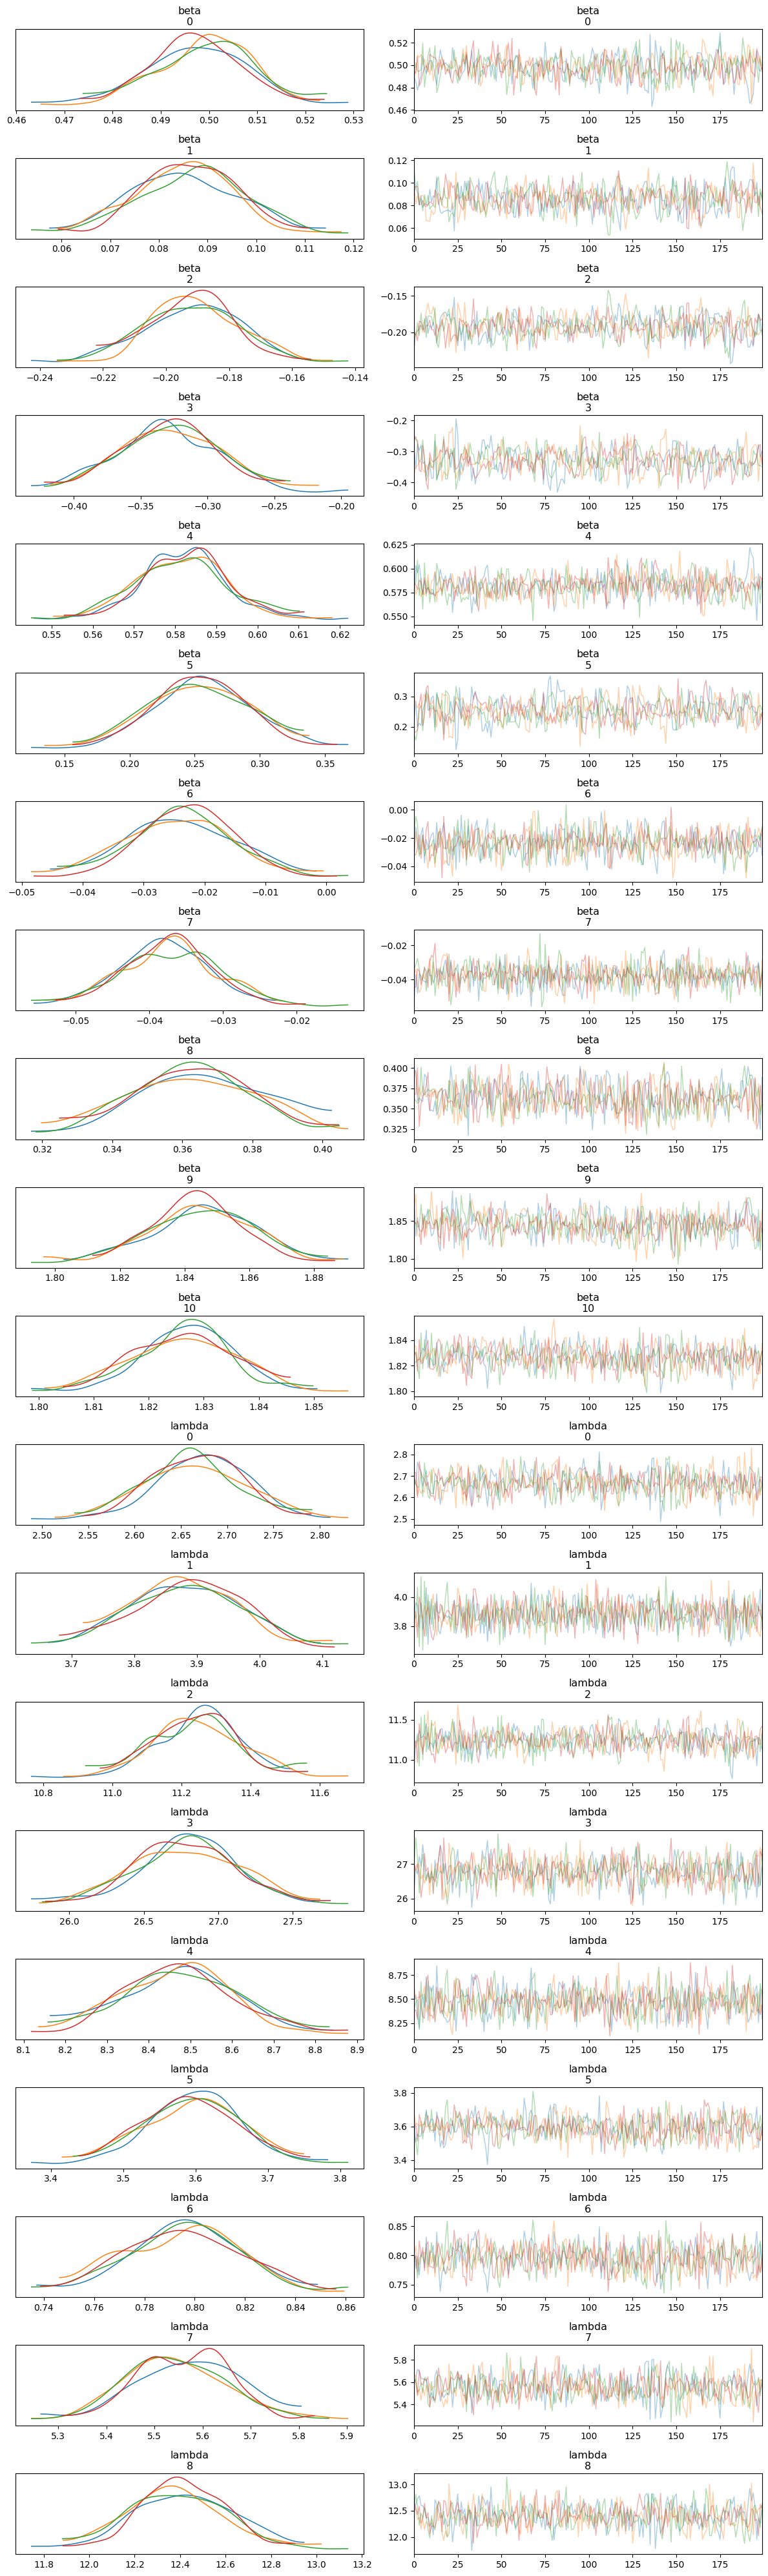

In [150]:
az.plot_trace(posterior_az_3, compact=False)
plt.tight_layout()
plt.show()

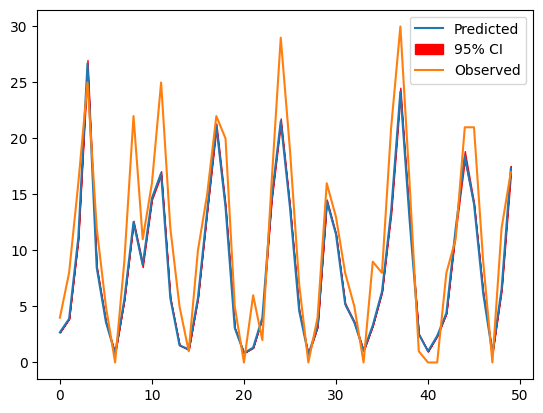

In [151]:
lam_3 = posterior_az_3['posterior']['lambda']

pred_3 = lam_3.mean(axis=0)
lower_3 = np.percentile(lam_3, 2.5, axis=0)
upper_3 = np.percentile(lam_3, 97.5, axis=0)

Y_no_stat = Y.loc[~Y['idSensore'].isin(stations_to_rm),:]
Y_no_stat = Y_no_stat.reset_index(drop=True)
x = np.arange(0, 50)
plt.plot(x, pred_3[0, x], label="Predicted")
plt.fill_between(x, lower_3[0,x], upper_3[0,x], alpha=1, label="95% CI", color='red')
plt.plot(x, Y_no_stat.loc[x, 'Count_120'], label="Observed")
plt.legend()
plt.show()

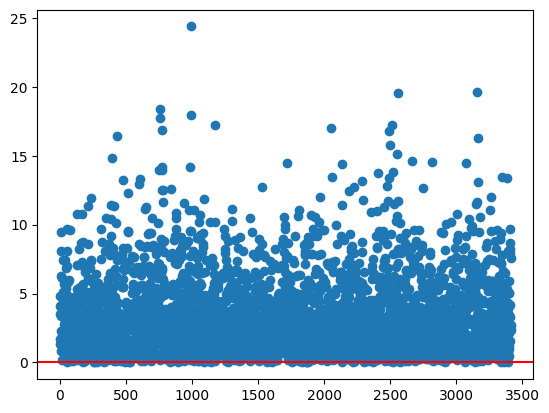

In [152]:
residuals_3 = np.abs(Y_no_stat['Count_120'] - pred_3.loc[0,:])

#plot these residuals
plt.scatter(np.arange(0, len(residuals_3)),residuals_3)
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [153]:
mae_3 = np.mean(residuals_3)
print(mae_3)
mse_3 = np.mean(residuals_3**2)
print(mse_3)

3.232236774392031
18.48544109505868


In [21]:
eta = posterior_az['posterior']['eta']
eta
len(np.unique(stations))

45

In [22]:
inference = []
for i in range(len(np.unique(stations))):
    ar1 = eta[0, :, i]
    ar2 = eta[1, :, i]
    ar3 = eta[2, :, i]
    ar4 = eta[3, :, i]
    current_iteration_df = np.concatenate((ar1, ar2, ar3, ar4), axis=0)
    inference.append(current_iteration_df)

len(current_iteration_df)
len(inference)

45

In [23]:
df = pd.DataFrame(inference).transpose()
df.shape
df.columns = np.unique(stations)
df.columns.values

array([ 5707,  5710,  5717,  5718,  5719,  5721,  5725,  5730,  5732,
        5735,  5738,  5739,  5742,  5749,  5750,  5952,  5960,  6582,
        6665,  6691,  6804,  6818,  6832,  6884,  6904,  9856,  9861,
        9882,  9899,  9925,  9972,  9991,  9997, 10025, 10041, 10081,
       10171, 10270, 10282, 10288, 10437, 10454, 10463, 10584, 12020],
      dtype=int64)

In [26]:
csv_path = '../Datasets/eta_120.csv'
data = pd.DataFrame(df)
# Save the DataFrame to a CSV file
data.to_csv(csv_path, index=False)